# Validation: Serial interval distribution sensitivity

This notebook:

* loads a library defined model. 
* loads the data according to the data preprocessor class.
* Tests the effect of serial interval distribution mean on cm effectiveness

In [46]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
### Initial imports
import logging
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as T
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import arviz as az
import copy

logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from epimodel.pymc3_models.utils import geom_convolution
from epimodel.pymc3_models import cm_effect
from epimodel.pymc3_models.cm_effect.datapreprocessor import DataPreprocessor
import sensitivityplotlib as spl


%matplotlib inline

In [48]:
dp = DataPreprocessor(drop_HS=True)
data = dp.preprocess_data("../final_data/data_final.csv")

INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Healthcare Infection Control
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Performing Smoothing
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Albania
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Andorra
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Estonia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Iceland
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Latvia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Lithuania
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing New Zealand
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Singapore
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Slovakia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Performing Masking


## build and run model
skip this if you already have traces 

In [49]:
serial_interval = [4, 5, 6, 7, 8] # 5.1 or 6.67 is the default value
model_types = ['combined', 'active', 'death', 'combined_v3']

In [20]:
for i in range(len(serial_interval)):
    for model_type in model_types:
        print('Serial interval mean: ' + str(serial_interval[i]))
        print('Model: ' + str(model_type))
        if model_type=='combined':
            with cm_effect.models.CMCombined_Final(data) as model:
                model.build_model(serial_interval_mean=serial_interval[i])  
        if model_type=='active':
            with cm_effect.models.CMActive_Final(data) as model:
                model.build_model(serial_interval_mean=serial_interval[i])  
        if model_type=='death':
            with cm_effect.models.CMDeath_Final(data) as model:
                model.build_model(serial_interval_mean=serial_interval[i]) 
        if model_type=='combined_v3':
            with cm_effect.models.CMCombined_Final_V3(data) as model:
                model.build_model(serial_interval_mean=serial_interval[i]) 
                    
        model.run(1000, chains=8, cores=8)
        filename = 'out_final/serial_int_' + model_type + '_SI' + str(serial_interval[i]) + '.txt'
        cm_trace = model.trace["CMReduction"]
        np.savetxt(filename, cm_trace)

Serial interval mean: 4
Model: combined
0.16770053475935834
0.6708021390374334


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...


HyperCMVar_log__             -0.77
CM_Alpha                     12.45
HyperRMean                    0.67
HyperRVar_log__              -0.77
RegionLogR                   28.31
GrowthCases                5389.30
GrowthDeaths               5389.30
InitialSizeCases_log       -198.07
Phi_1_log__                  -0.77
InitialSizeDeaths_log      -198.07
ObservedCases           -286101.51
ObservedDeaths          -241454.85
Name: Log-probability of test_point, dtype: float64


KeyboardInterrupt: 

### Plot traces 

In [ ]:
plt.figure()
model.plot_traces()

### Plot countermeasure effectiveness

In [56]:
cm_labels = data.CMs
legend_labels = copy.deepcopy(serial_interval)
index_default=2
legend_labels.insert(index_default, 'default')
legend_title = 'Serial Interval Mean'
legend_fontsize=6
out_dir = 'out_SI_2'

##### plot combined

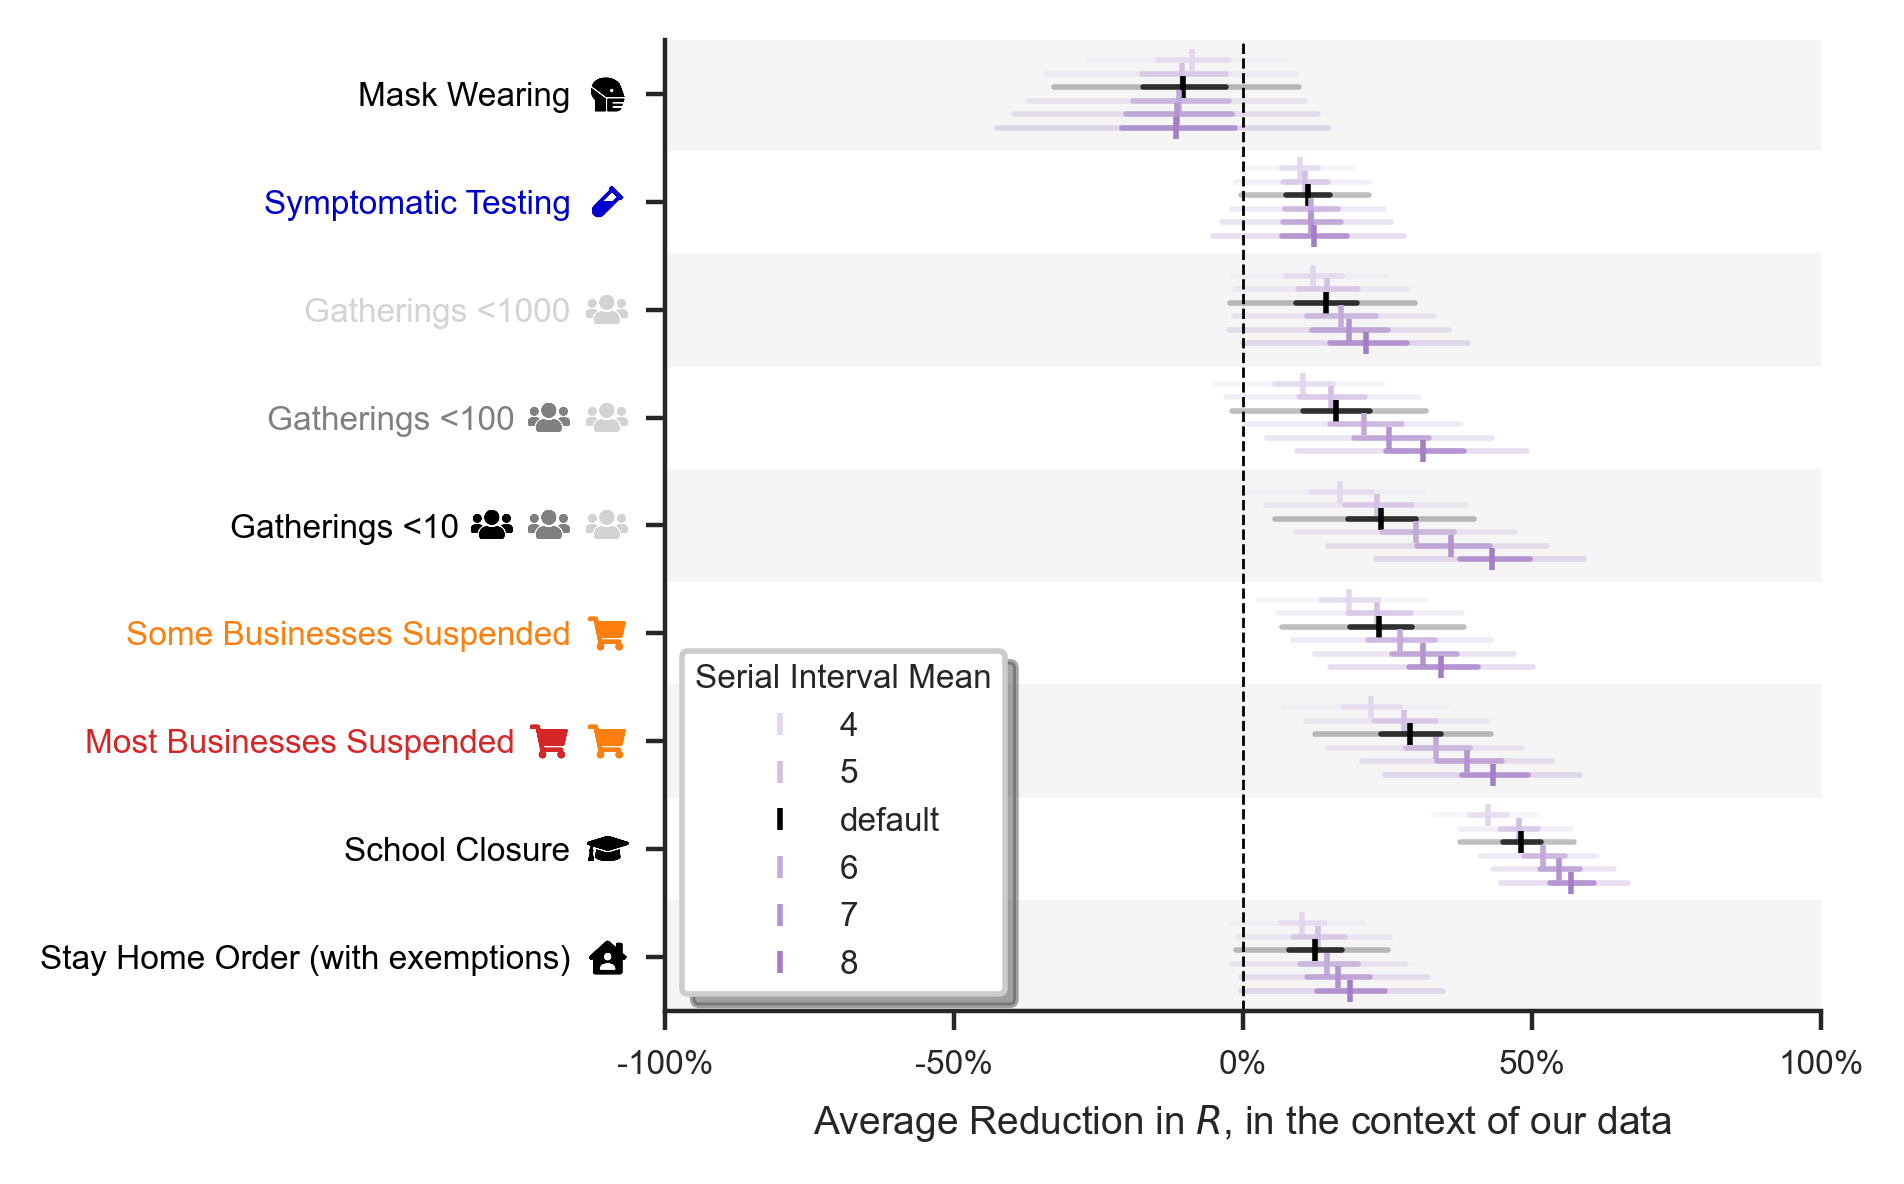

In [57]:
colors= sns.light_palette("tab:purple",n_colors=len(legend_labels)+1)#sns.color_palette('Purples', 6)
colors.pop(0)
colors.insert(index_default,[0,0,0])

filenames = [f'%s/serial_int_combined_SI{si}.txt'%out_dir for si in serial_interval]
filenames.insert(index_default, out_dir + '/default_combined.txt')
spl.plot_cm_effect_sensitivity_v2(filenames, cm_labels, legend_labels, 
                               colors=colors, 
                               legend_title=legend_title, 
                               legend_fontsize=legend_fontsize)
plt.savefig(out_dir + '/serial_int_sensitivity_combined.pdf')

##### plot active

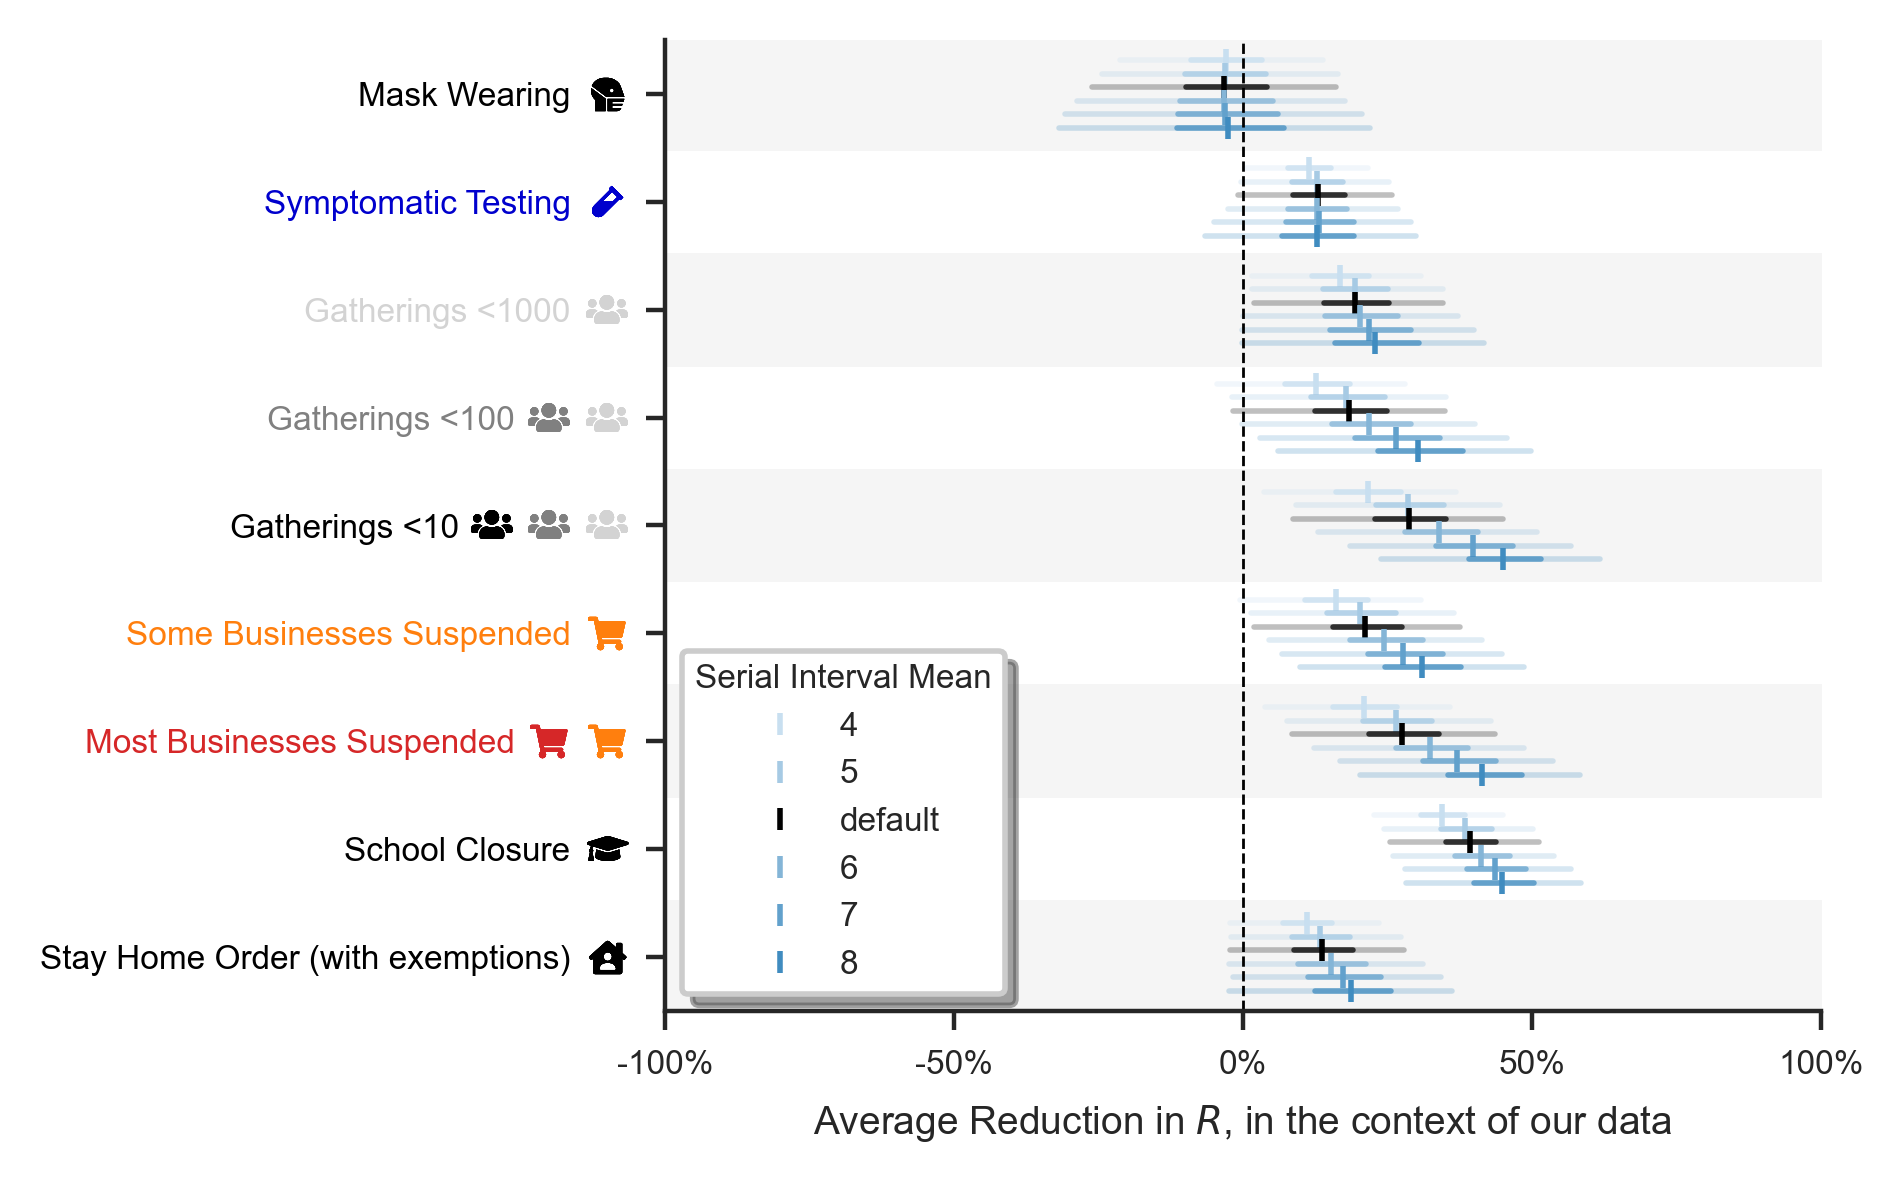

In [58]:
colors= sns.light_palette("tab:blue",n_colors=len(legend_labels)+1)#sns.color_palette('Purples', 6)
colors.pop(0)
colors.insert(index_default,[0,0,0])

filenames = [f'%s/serial_int_active_SI{si}.txt'%out_dir for si in serial_interval]
filenames.insert(index_default, out_dir + '/default_active.txt')
spl.plot_cm_effect_sensitivity_v2(filenames, cm_labels, legend_labels, 
                               colors=colors, 
                               legend_title=legend_title, 
                               legend_fontsize=legend_fontsize)
plt.savefig(out_dir + '/serial_int_sensitivity_active.pdf')

##### plot deaths

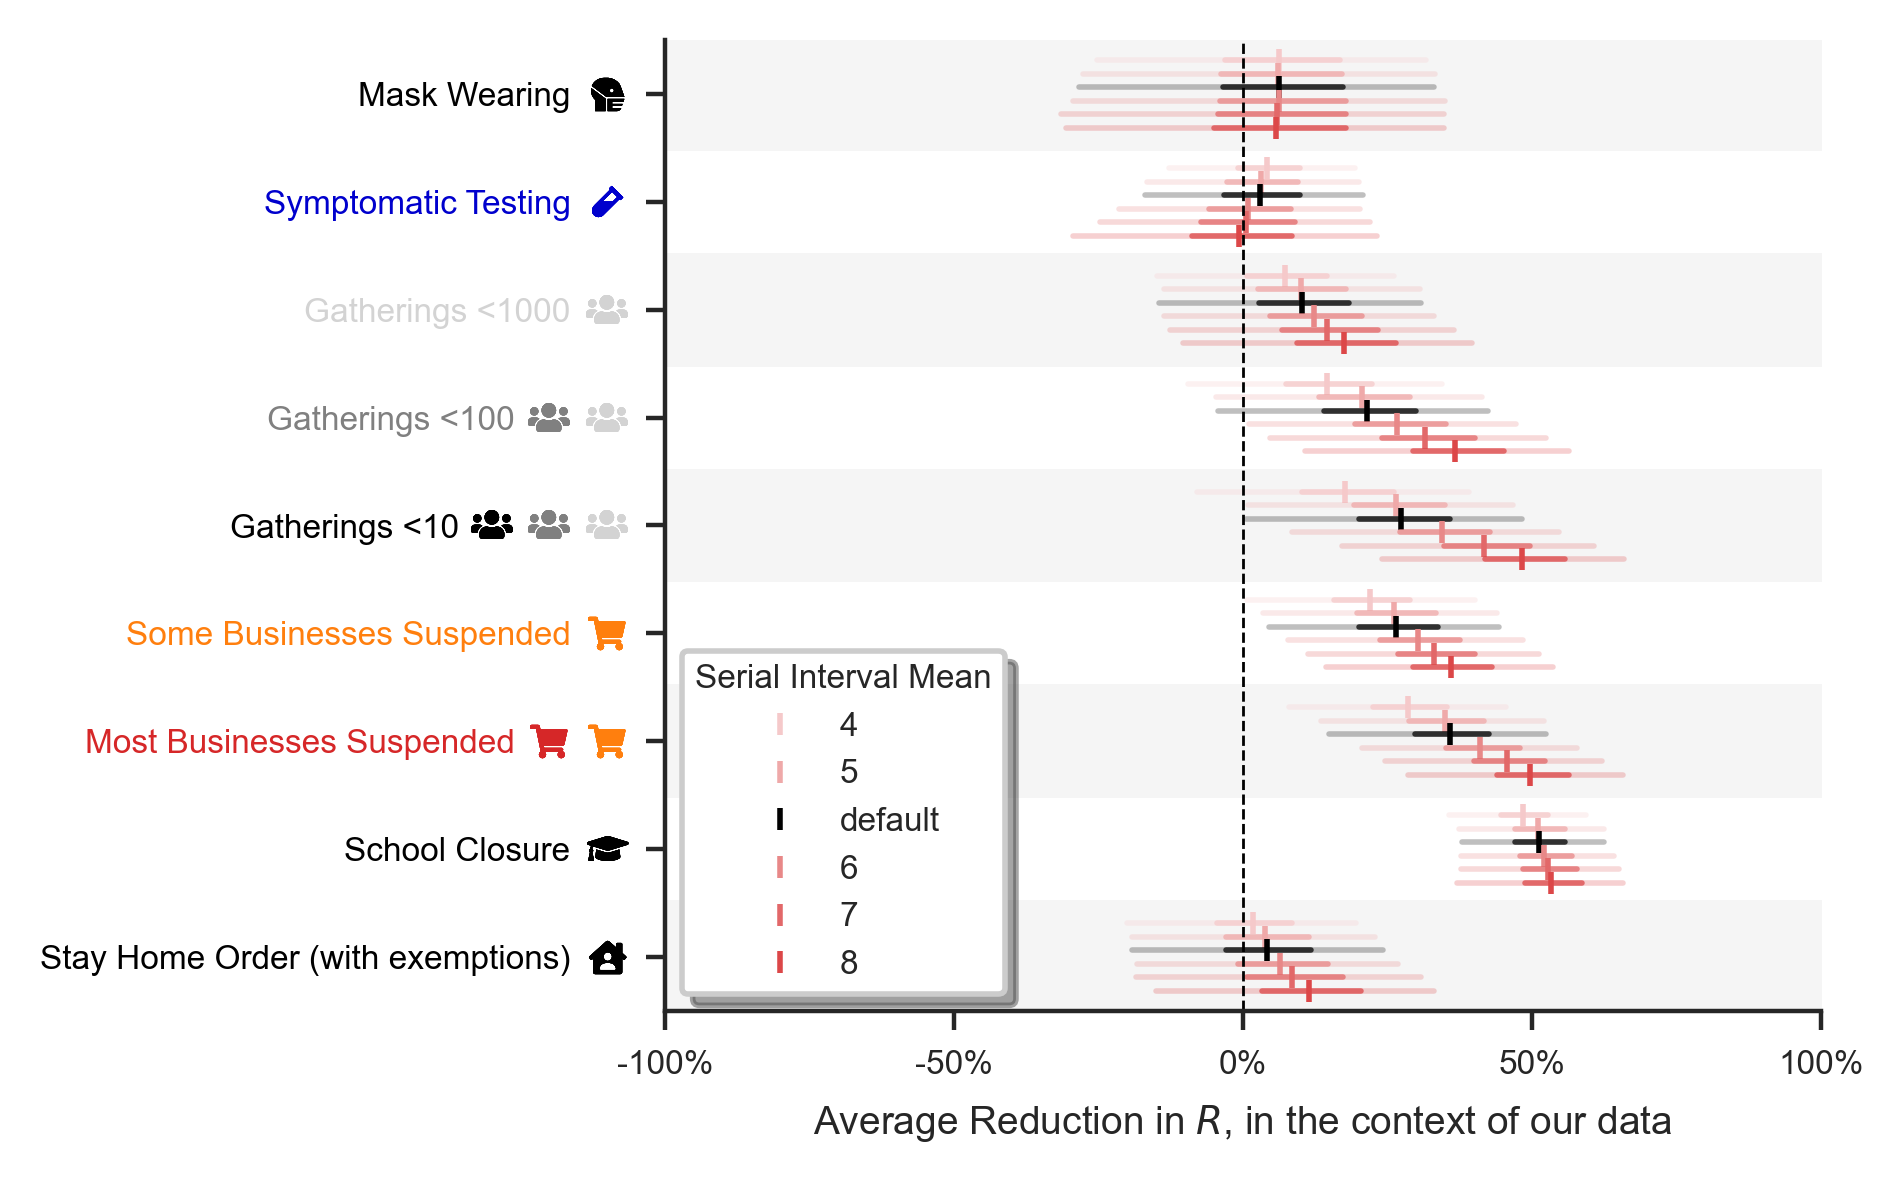

In [60]:
colors= sns.light_palette("tab:red",n_colors=len(legend_labels)+1)#sns.color_palette('Purples', 6)
colors.pop(0)
colors.insert(index_default,[0,0,0])

filenames = [f'%s/serial_int_death_SI{si}.txt'%out_dir for si in serial_interval]
filenames.insert(index_default, out_dir + '/default_death.txt')
spl.plot_cm_effect_sensitivity_v2(filenames, cm_labels, legend_labels, 
                               colors=colors, 
                               legend_title=legend_title, 
                               legend_fontsize=legend_fontsize)
plt.savefig(out_dir + '/serial_int_sensitivity_death.pdf')